In [11]:
import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from skimage import io
from skimage.transform import rescale, resize

import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
from skimage import io
from skimage.transform import rescale, resize

import matplotlib.pyplot as plt
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import numpy as np
from keras.models import Model
from keras.layers import Input, Conv2D, Activation, Concatenate, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing import image

import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
layers =  tf.keras.layers
models =tf.keras.models

In [12]:
from pathlib import Path
Path('/kaggle/working/Cancer_Data').mkdir(parents=True, exist_ok=True)
Path('/kaggle/working/Cancer_Data/HGSC').mkdir(parents=True, exist_ok=True)
Path('/kaggle/working/Cancer_Data/EC').mkdir(parents=True, exist_ok=True)
Path('/kaggle/working/Cancer_Data/CC').mkdir(parents=True, exist_ok=True)
Path('/kaggle/working/Cancer_Data/MC').mkdir(parents=True, exist_ok=True)
Path('/kaggle/working/Cancer_Data/LGSC').mkdir(parents=True, exist_ok=True)

In [13]:
import cv2
import os

def process_images_with_keyword(keyword):
    #  read the CSV file into the DataFrame 'df'
    df = pd.read_csv('/kaggle/input/UBC-OCEAN/train.csv')

    # Compare the text in the column with the provided keyword
    comparison_result = df['label'].str.contains(keyword, case=False)

    # Use the comparison result
    filtered_data = df[comparison_result]

    # Get the "image_id" column and convert it to strings
    image_ids = filtered_data['image_id'].astype(str)

    # Define the source and destination directories
    source_directory = '/kaggle/input/UBC-OCEAN/train_thumbnails/'
    destination_directory = f'/kaggle/working/Cancer_Data/{keyword}/'

    # Create the destination directory if it doesn't exist
    os.makedirs(destination_directory, exist_ok=True)

    # Iterate through image_ids, read images, and save resized images
    for image_id in image_ids:
        source_path = os.path.join(source_directory, f"{image_id}_thumbnail.png")
        destination_path = os.path.join(destination_directory, f"{image_id}.png")
        
        # Load the image
        image = cv2.imread(source_path)
        
        if image is not None:
            # Resize the image
            resized_image = cv2.resize(image, (224, 224))
            
            # Save the resized image
            cv2.imwrite(destination_path, resized_image)
        
        # Print the paths for reference
      #  print("Source Path:", source_path)
      #  print("Destination Path:", destination_path)

In [14]:
process_images_with_keyword("CC")
process_images_with_keyword("EC")
process_images_with_keyword("HGSC")
process_images_with_keyword("LGSC")
process_images_with_keyword("MC")

[ WARN:0@1305.579] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/UBC-OCEAN/train_thumbnails/36302_thumbnail.png'): can't open/read file: check file path/integrity
[ WARN:0@1306.592] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/UBC-OCEAN/train_thumbnails/41586_thumbnail.png'): can't open/read file: check file path/integrity
[ WARN:0@1307.217] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/UBC-OCEAN/train_thumbnails/42857_thumbnail.png'): can't open/read file: check file path/integrity
[ WARN:0@1307.978] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/UBC-OCEAN/train_thumbnails/44603_thumbnail.png'): can't open/read file: check file path/integrity
[ WARN:0@1310.981] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/UBC-OCEAN/train_thumbnails/57696_thumbnail.png'): can't open/read file: check file path/integrity
[ WARN:0@1324.563] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/UBC-OCEAN/train_thumbnails/31594_thumbnail

In [15]:
image_set= '/kaggle/working/Cancer_Data/'
for i,d in enumerate([image_set]):
    filepaths=[]
    labels=[]
    classlist=os.listdir(d)
    for klass in classlist:
        classpath=os.path.join(d,klass)
        if os.path.isdir(classpath):
            flist=os.listdir(classpath)
            for f in flist:
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(klass)
    Fseries= pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    lung_df=pd.concat([Fseries, Lseries], axis=1)
df=pd.concat([lung_df], axis =0).reset_index(drop=True)# make a combined dataframe

print(df['labels'].value_counts())

labels
HGSC    217
EC      119
CC       94
LGSC     42
MC       41
Name: count, dtype: int64


In [16]:
from sklearn.model_selection import train_test_split
train_split=.5
test_split=.25
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), ' _test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  256  _test_df length:  128   valid_df length:  129


In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
height=224
width=224
channels=3
batch_size=8
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):
    return img/127.5-1  # scale pixel between -1 and +1
gen=ImageDataGenerator(preprocessing_function=scalar)
train_set=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_set=gen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
validate_set=gen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

test batch size:  64   test steps:  2
Found 256 validated image filenames belonging to 5 classes.
Found 128 validated image filenames belonging to 5 classes.
Found 129 validated image filenames belonging to 5 classes.


In [18]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
model= keras.models.Sequential()

model.add(keras.layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Conv2D(64, 3, activation='relu'))
model.add(keras.layers.Dropout(0.15))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Conv2D(128, 3, activation='relu'))
model.add(keras.layers.Dropout(0.15))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(5, activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
#executing the model
history = model.fit(train_set, validation_data = (validate_set), epochs = 30, verbose = 1)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 dropout_3 (Dropout)         (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 dropout_4 (Dropout)         (None, 109, 109, 64)      0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                 

2/2 [==============================] - 2s 1s/step
Classification Report
              precision    recall  f1-score   support

          CC       0.00      0.00      0.00        19
          EC       0.12      0.14      0.13        28
        HGSC       0.39      0.49      0.44        61
        LGSC       0.00      0.00      0.00         7
          MC       0.00      0.00      0.00        13

    accuracy                           0.27       128
   macro avg       0.10      0.13      0.11       128
weighted avg       0.21      0.27      0.24       128



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

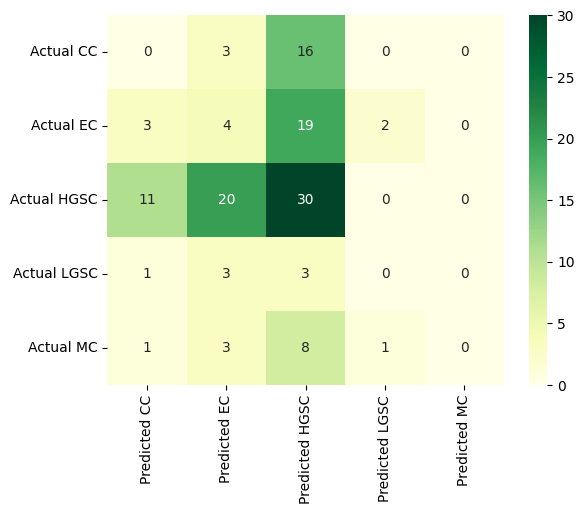

In [19]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
Y_pred = model.predict(test_set)
y_pred = np.argmax(Y_pred ,axis =1)

preds = model.predict(test_set,verbose=1)
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

print('Classification Report')
target_names = ['CC','EC','HGSC','LGSC','MC']
print(classification_report(test_set.classes, y_pred, target_names=target_names))

from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix( y_true= test_set.classes, y_pred= y_pred, labels=[0, 1,2,3,4]), index=['Actual CC','Actual EC','Actual HGSC','Actual LGSC', 'Actual MC'],columns=['Predicted CC','Predicted EC','Predicted HGSC','Predicted LGSC', 'Predicted MC'])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d",cmap="YlGn")

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

height = 224
width = 224
channels = 3
batch_size = 8
img_shape = (height, width, channels)
img_size = (height, width)
length = len(test_df)
test_batch_size = sorted([int(length / n) for n in range(1, length + 1) if length % n == 0 and length / n <= 80], reverse=True)[0]
test_steps = int(length / test_batch_size)
print('test batch size:', test_batch_size, '  test steps:', test_steps)

# Defining the augmentation function
def augment(image):
    # Apply augmentation techniques here
    # Example: use the ImageDataGenerator for augmentation
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        preprocessing_function=scalar
    )
    return datagen.random_transform(image)

# Define the scalar function
def scalar(img):
    return img / 127.5 - 1  # scale pixel between -1 and +1

gen = ImageDataGenerator(preprocessing_function=augment)

train_set = gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                    class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

test_set = gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)

validate_set = gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)


test batch size: 64   test steps: 2
Found 256 validated image filenames belonging to 5 classes.
Found 128 validated image filenames belonging to 5 classes.
Found 129 validated image filenames belonging to 5 classes.


In [21]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
model= keras.models.Sequential()

model.add(keras.layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Conv2D(64, 3, activation='relu'))
model.add(keras.layers.Dropout(0.15))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Conv2D(128, 3, activation='relu'))
model.add(keras.layers.Dropout(0.15))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(5, activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
#executing the model
history = model.fit(train_set, validation_data = (validate_set), epochs = 30, verbose = 1)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 dropout_6 (Dropout)         (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 dropout_7 (Dropout)         (None, 109, 109, 64)      0         
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                 

2/2 [==============================] - 4s 1s/step
Classification Report
              precision    recall  f1-score   support

          CC       0.00      0.00      0.00        19
          EC       0.00      0.00      0.00        28
        HGSC       0.48      1.00      0.65        61
        LGSC       0.00      0.00      0.00         7
          MC       0.00      0.00      0.00        13

    accuracy                           0.48       128
   macro avg       0.10      0.20      0.13       128
weighted avg       0.23      0.48      0.31       128



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

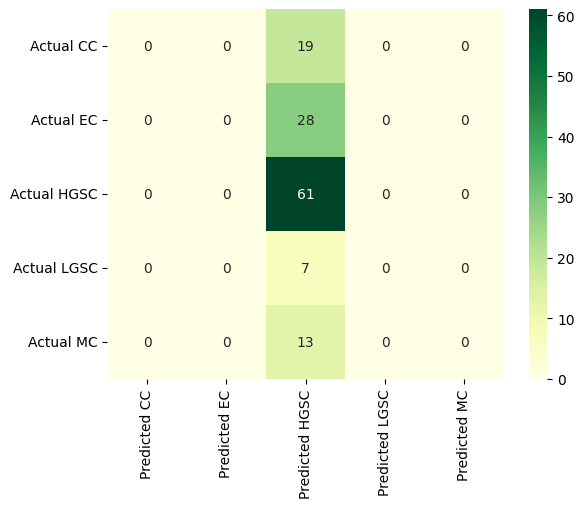

In [22]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
Y_pred = model.predict(test_set)
y_pred = np.argmax(Y_pred ,axis =1)

preds = model.predict(test_set,verbose=1)
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

print('Classification Report')
target_names = ['CC','EC','HGSC','LGSC','MC']
print(classification_report(test_set.classes, y_pred, target_names=target_names))

from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix( y_true= test_set.classes, y_pred= y_pred, labels=[0, 1,2,3,4]), index=['Actual CC','Actual EC','Actual HGSC','Actual LGSC', 'Actual MC'],columns=['Predicted CC','Predicted EC','Predicted HGSC','Predicted LGSC', 'Predicted MC'])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d",cmap="YlGn")

In [ ]:
from keras.applications import MobileNet

from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input

img_size = [224, 224]
MobileNet = MobileNet(input_shape=img_size + [3], weights='imagenet', include_top=False)# don't train existing weights
# don't train existing weights
for layer in MobileNet.layers:
    layer.trainable = False

flatten = Flatten()(MobileNet.output)
dense = Dense(256, activation = 'relu')(flatten)
dense = Dense(128, activation = 'relu')(dense)
prediction = Dense(5, activation = 'softmax')(dense)
    

#creating a model
model_2 = Model(inputs = MobileNet.input, outputs = prediction )
model_2.summary()

model_2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
#executing the model
history = model_2.fit(train_set, validation_data = (validate_set), epochs = 50, verbose = 1)

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
Y_pred = model_2.predict(test_set)
y_pred = np.argmax(Y_pred ,axis =1)
preds = model_2.predict(test_set,verbose=1)
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

print('Classification Report')
target_names = ['CC','EC','HGSC','LGSC','MC']
print(classification_report(test_set.classes, y_pred, target_names=target_names))

from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix( y_true= test_set.classes, y_pred= y_pred, labels=[0, 1,2,3,4]), index=['Actual CC','Actual EC','Actual HGSC','Actual LGSC', 'Actual MC'],columns=['Predicted CC','Predicted EC','Predicted HGSC','Predicted LGSC', 'Predicted MC'])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d",cmap="YlGn")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

In [ ]:
#Test thumbnail
from skimage.io import imread

from matplotlib.pyplot import imshow
img = imread("/kaggle/input/UBC-OCEAN/test_thumbnails/41_thumbnail.png")
imshow(img)
print(f"Original Dimensions : {img.shape}")

In [ ]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):

  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

def pred_and_plot(model, filename, target_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = target_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False)


In [ ]:
# Test our model on a test image
pred_and_plot(model_2, "/kaggle/working/Cancer_Data/CC/45725.png", target_names)